In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# XGBoost 

Set up cross validation, model creation functions and model tuning 

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

## Load Data and Create Features / Labels

In [3]:
df = pd.read_csv('../../data/raw/training.csv', index_col=0)
# df.replace(-1, 99, inplace=True)

X = df.drop(['mobile_money','savings','borrowing','insurance','mobile_money_classification'], axis=1)
y = df['mobile_money_classification']

X.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Latitude,Longitude
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,2,-1,2,-1,1,-1,4,4,-4.460442,29.811396
1258,40,1,1,3,5,1,1,1,0,0,...,1,4,1,5,4,4,1,4,-6.176438,39.244871
331,18,2,4,6,3,2,1,0,0,0,...,2,-1,2,-1,1,-1,1,1,-6.825702,37.652798
6729,50,1,1,3,1,1,1,0,0,0,...,1,2,2,-1,4,-1,1,4,-3.372049,35.808307
8671,34,1,1,1,1,2,1,0,1,0,...,2,-1,1,1,1,-1,1,4,-7.179645,31.039095


### Select 10% for independent testing

Modelling Dataset:
(6384, 31)


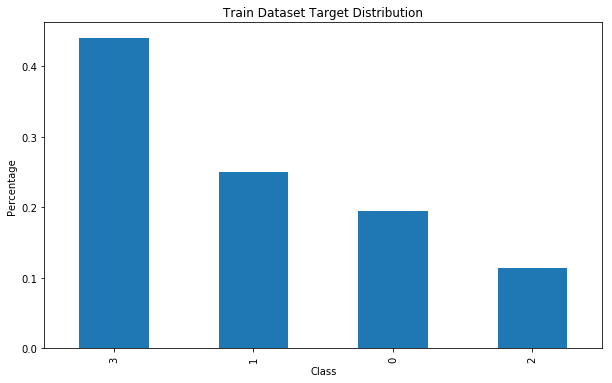

In [4]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

print("Modelling Dataset:")
print(X.shape)
plot = y.value_counts(normalize=True).plot(kind='bar', title='Train Dataset Target Distribution', figsize=(10,6))
plot.set_xlabel('Class')
plot.set_ylabel('Percentage');

Testing Dataset: 
(710, 31)


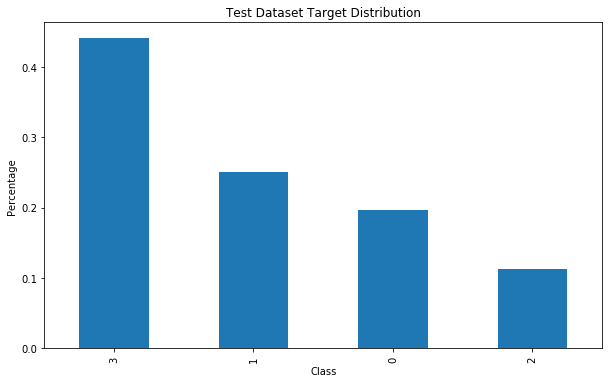

In [5]:
print("Testing Dataset: ")
print(X_test.shape)
plot2 = y_test.value_counts(normalize=True).plot(kind='bar', title='Test Dataset Target Distribution', figsize=(10,6))
plot2.set_xlabel('Class')
plot2.set_ylabel('Percentage');

## Create XBoost Model

In [6]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

seed = 2019

np.random.seed(seed)

n_classes = y.nunique()

# Params that won't be changed
static_params = {
    'objective': 'multi:softprob', #multiclass classification, but output probabilities not classes
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'seed': 2019
}

# Some default params to start with
starter_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'gamma': 0,
    'min_child_weight': 1,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'scale_pos_weight': 1
}
# Combine parameters sets into one
xgb_params = {**static_params, **starter_params}
xgb_params.update(starter_params)

### Create Preprocessing and Feature Extraction Pipeline(s)

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from src.features.transformers import ColumnExtractor, MMAgentsInVicinity
from sklearn.feature_selection import VarianceThreshold

from category_encoders import BinaryEncoder

def create_cats(x, cat_vars):
    cats = [list(range(low, high+1)) for low, high in zip(x[cat_vars].min(), x[cat_vars].max())]
    return cats

CONT_VARS = ['Q1']
CAT_VARS = ['Q2','Q3','Q4','Q5','Q6','Q7','Q8_1',
            'Q8_2','Q8_3','Q8_4','Q8_5','Q8_6',
            'Q8_7','Q8_8','Q8_9','Q8_10','Q8_11',
            'Q9','Q10','Q11','Q12','Q13','Q14',
            'Q15','Q16','Q17','Q18','Q19']
LAT_LON = ['Latitude','Longitude']

features = []
n_bins=7
continuous_pipeline = Pipeline([
        ('extract', ColumnExtractor(CONT_VARS)),
        ('discretize', KBinsDiscretizer(n_bins=n_bins, encode='onehot-dense'))
])

# Add continuous feature names
features.extend([f'{f}_{i}' for f in CONT_VARS for i in range(1,n_bins+1)])

categorical_pipeline = Pipeline([
        ('extract', ColumnExtractor(CAT_VARS)),
#         ('encode', BinaryEncoder(cols=CAT_VARS)),
])
# Just the categories for now
features.extend(CAT_VARS)

location_pipeline = Pipeline([
        ('extract', ColumnExtractor(LAT_LON)),
        ('mm_agents_5km', MMAgentsInVicinity(radius=5))
])
features.extend(['mm_agents_5km'])

# Combine individual pipelines
preprocessing_pipeline = FeatureUnion([
    ('continuous', continuous_pipeline),
    ('categorical', categorical_pipeline),
    ('location', location_pipeline)
])

In [27]:
from sklearn_pandas import DataFrameMapper, gen_features

# Continuous feature maps
con_maps = gen_features(
    columns=[[c] for c in CONT_VARS], 
    classes=[{'class': KBinsDiscretizer, 'n_bins': 7, 'encode': 'onehot-dense'}]
)

# Categorical Feature maps
# Just select the columns for now
cat_maps = gen_features([[c] for c in CAT_VARS])

# Location Feature maps
loc_maps = [
    (LAT_LON, MMAgentsInVicinity(radius=5), {'alias': 'mobile_money_agents'})
]

feature_maps = con_maps + cat_maps + loc_maps

features_pipeline = DataFrameMapper(feature_maps, df_out=True)

features_pipeline.fit_transform(X)

,Q1_0,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q2,Q3,Q4,...,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,mobile_money_agents
ID,,,,,,,,,,,,,,,,,,,,,
6964,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,2,3,...,-1,2,-1,2,-1,1,-1,1,4,0
5319,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1,3,...,-1,2,-1,2,-1,1,-1,1,4,3
8401,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,3,2,...,-1,2,-1,2,-1,1,-1,4,4,0
7810,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,3,...,-1,1,6,2,-1,1,-1,1,2,0
7801,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,2,...,-1,1,4,1,4,1,-1,1,4,14
8289,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,1,...,-1,2,-1,1,6,1,-1,4,4,0
600,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,3,...,-1,1,2,2,-1,2,4,1,4,3
4022,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,...,-1,2,-1,2,-1,1,-1,4,4,0
6437,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,4,1,...,-1,2,-1,2,-1,1,-1,4,4,49


In [24]:
gen_features([LAT_LON], [{'class': MMAgentsInVicinity, 'radius': 5}])

[(['Latitude', 'Longitude'], [MMAgentsInVicinity(mm_coords=None, radius=5)])]

In [26]:
[(LAT_LON, MMAgentsInVicinity(radius=5), {'alias': 'mobile_money_agents'})]

[(['Latitude', 'Longitude'],
  MMAgentsInVicinity(mm_coords=None, radius=5),
  {'alias': 'mobile_money_agents'})]

In [19]:
%debug

> /Users/renier.botha/dev/personal/ds/zindi/mobile_money_tanzania/src/features/transformers.py(29)transform()
     27 
     28     def transform(self, X, y=None):
---> 29         x_coords = X[['Latitude', 'Longitude']]
     30 
     31         agents_in_radius = x_coords.apply(



ipdb>  print(X.shape)


(6384, 2)


ipdb>  quit


## Train Basic Model on Pipeline

In [43]:
X_proc = preprocessing_pipeline.fit_transform(X)
X_proc = pd.DataFrame(X_proc, columns=features)
X_proc.head()

,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q2,Q3,Q4,...,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,mm_agents_5km
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1.0,2.0,-1.0,1.0,4.0,1.0,-1.0,4.0,4.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,...,-1.0,2.0,-1.0,1.0,6.0,1.0,-1.0,4.0,4.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,4.0,4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,2.0,4.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,1.0,4.0,1.0


In [14]:
model = XGBClassifier(missing=-1, **xgb_params)
model.fit(X_proc, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=-1, n_estimators=500, n_jobs=1,
       nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=True, subsample=0.8)

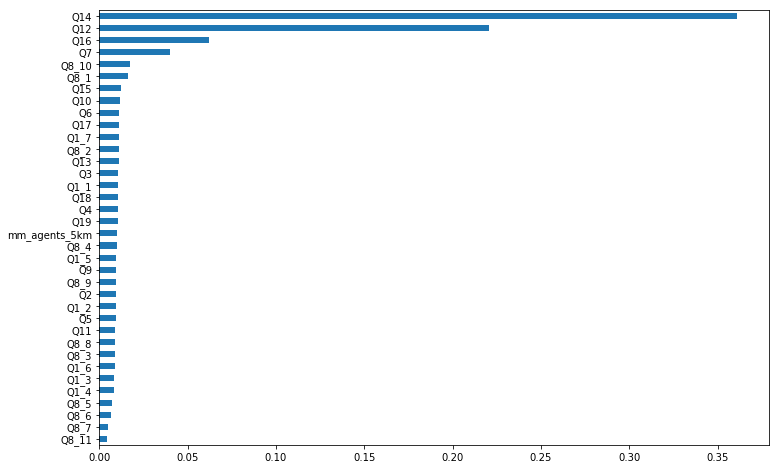

In [15]:
import matplotlib.pyplot as plt
feat_imp = pd.Series(model.feature_importances_, index=features).sort_values()
feat_imp.plot.barh(figsize=(12,8))

## Hyper Parameter Tuning Using `skopt`

In [17]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from IPython.display import clear_output

class ConvergencePlotCallback(object):
    def __init__(self, figsize=(12,8)):
        self.fig = plt.figure(figsize=figsize)

    def __call__(self, res):
        clear_output(wait=True)
        plot_convergence(res)
        plt.show()
        
skf = StratifiedKFold(n_splits=5)
plot_callback = ConvergencePlotCallback(figsize=(12,8));

<Figure size 864x576 with 0 Axes>

In [20]:
space = [
    Integer(1, 5, name='max_depth'),
    Real(1e-5, 1, "log-uniform", name='learning_rate'),
    Integer(1, 5, name='min_child_weight'),
    Real(0.001, 4, "log-uniform", name='gamma'),
    Real(0.5, 1.0, "uniform", name="subsample"),
    Real(0.5, 1.0, "uniform", name='colsample_bytree'),
    Real(1e-5, 100, "log-uniform", name="reg_alpha")
]

@use_named_args(space)
def objective(**params):
    
    new_params = {**xgb_params}
    new_params.update(**params)
    
    pipeline = Pipeline([
        ('features',preprocessing_pipeline),
        ('classifier', XGBClassifier(**new_params))
    ])
    
    score = -np.mean(cross_val_score(pipeline, X, y, cv=skf, n_jobs=-1, scoring='neg_log_loss'))
    
    return score

def to_named_params(params, space=space):
    return({dimension.name: param for dimension, param in zip(SPACE, params)})


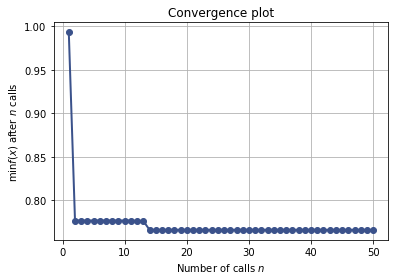

In [55]:
gp_results = gp_minimize(objective, space, n_calls=50, random_state=2019, callback=[plot_callback])

## Train model on optimum params

In [ ]:
best_params = to_named_params(gp_results.x)
opt_params = {**static_params, **best_params}

best_model = XGBClassifier(**opt_params)

best_model.fit(X_proc, y)

In [37]:
best_params = {'max_depth': 2,
 'learning_rate': 0.045055093989804396,
 'min_child_weight': 5,
 'gamma': 0.016880047584747072,
 'subsample': 0.5,
 'colsample_bytree': 0.5,
 'reg_alpha': 0.0007967773809231392}

opt_params = {**static_params, **best_params}

best_model = XGBClassifier(**opt_params)

best_model.fit(X_proc, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='mlogloss',
       gamma=0.016880047584747072, learning_rate=0.045055093989804396,
       max_delta_step=0, max_depth=2, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_class=4,
       objective='multi:softprob', random_state=0,
       reg_alpha=0.0007967773809231392, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=True, subsample=0.5)

## Inspect Predictions

### Create features from test data

In [44]:
X_test_proc = preprocessing_pipeline.fit_transform(X_test)
X_test_proc = pd.DataFrame(X_test_proc, columns=features)
X_test_proc.head()

,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q2,Q3,Q4,...,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,mm_agents_5km
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,1.0,4.0,29.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,...,-1.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,2.0,4.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,...,-1.0,2.0,-1.0,1.0,6.0,5.0,-1.0,1.0,4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,...,4.0,2.0,-1.0,2.0,-1.0,1.0,-1.0,5.0,5.0,1267.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,...,-1.0,1.0,2.0,1.0,2.0,4.0,-1.0,2.0,4.0,290.0


### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

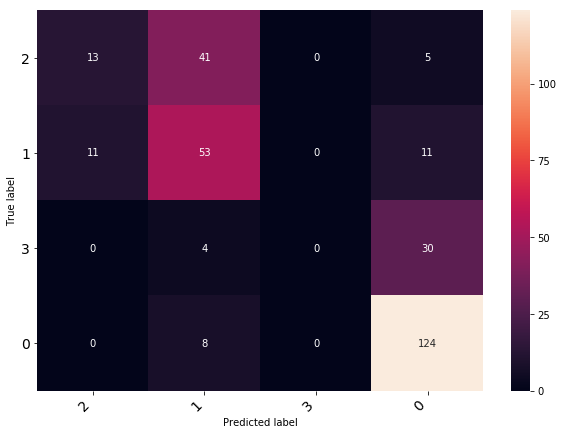

In [48]:
test_preds = best_model.predict(X_test_proc)

class_names = y_test.unique()

cm = confusion_matrix(y_test, test_preds)

plot = print_confusion_matrix(cm, class_names)

## Make Submission

In [75]:
from src.utils import make_sub

In [76]:
X_test = pd.read_csv('../../data/raw/test.csv', index_col=0)

X_test_proc = preprocessing_pipeline.transform(X_test)

In [77]:
test_probs = best_model.predict_proba(X_test_proc)

sub_df = make_sub(test_probs)

sub_df.head()

,no_financial_services,other_only,mm_only,mm_plus
2352,0.000266,0.000729,0.218578,0.780427
8208,0.023080,0.046868,0.186810,0.743242
2785,0.000868,0.007127,0.106930,0.885075
2967,0.404901,0.520744,0.019177,0.055178
1697,0.000163,0.001275,0.126783,0.871779


In [78]:
sub_df.to_csv('../../data/submissions/xgb_baseline_tuned.csv')